# EWB paper figure 1: showing all the cases

We provide the exact code used to generate each figure in order to be completely reproducible and to encourage others to use EWB with their own models quickly. 
This is Figure 1, the initial figure that shows all of the cases, both globally and then zoomed in

In [9]:
# setup all the imports
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import yaml
import urllib.request
import matplotlib.font_manager
flist = matplotlib.font_manager.get_font_names()
from tempfile import NamedTemporaryFile
import urllib
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import matplotlib.patches as patches
from extremeweatherbench import evaluate, events, config, utils
sns.set_theme(style='whitegrid')
from shapely.geometry import Polygon
import shapely

In [10]:
import dataclasses

@dataclasses.dataclass
class SevereConvection(events.EventContainer):
    """A container class to hold a list of cases of severe convection events."""

    event_type: str = "severe_convection"

@dataclasses.dataclass
class AtmosphericRiver(events.EventContainer):
    """A container class to hold a list of cases of heat wave events."""

    event_type: str = "atmospheric_river"

@dataclasses.dataclass
class TropicalCyclone(events.EventContainer):
    """A container class to hold a list of cases of freeze events."""

    event_type: str = "tropical_cyclone"


full_event_list = [events.HeatWave,
              events.Freeze,
              SevereConvection,
              AtmosphericRiver,
              TropicalCyclone,
              ]

full_configuration = config.Config(
    event_types=full_event_list,
    )
cases = evaluate.get_case_metadata(eval_config=full_configuration)

In [11]:
# useful for debugging
for event in cases:
    for indiv_case in event.cases:
        if (indiv_case.case_id_number == 33):
            print(indiv_case.location.geopandas)
        


                                            geometry
0  POLYGON ((118.9737 28.7304, 123.9737 28.7304, ...


In [12]:
# helper functions to make the main plotting function cleaner
# helper function to convert a bounding box tuple to a shapely Polygon
def get_polygon_from_bounding_box(bounding_box):
    """Convert a bounding box tuple to a shapely Polygon."""
    if bounding_box is None:
        return None
    left_lon, right_lon, bot_lat, top_lat = bounding_box
    return Polygon(
        [
            (left_lon, bot_lat),
            (right_lon, bot_lat),
            (right_lon, top_lat),
            (left_lon, top_lat),
            (left_lon, bot_lat),
        ]
    )

# helper function to plot a polygon on a cartopy axis
def plot_polygon(polygon, ax, color='yellow', alpha=0.5):
    """Plot a shapely Polygon on a Cartopy axis."""
    if polygon is None:
        return
    patch = patches.Polygon(
        polygon.exterior.coords,
        closed=True,
        facecolor=color,
        edgecolor='black',
        alpha=alpha,
        transform=ccrs.PlateCarree()
    )
    ax.add_patch(patch)

# main plotting function for plotting all cases
def plot_all_cases(cases, event_type=None, filename=None, bounding_box=None):
    """A function to plot all cases
    Args:
        cases (list): A list of cases to plot.
        event_type (str): The type of event to plot. If None, all events will be plotted).
        filename (str): The name of the file to save the plot. If None, the plot will not be saved.
        bounding_box (tuple): A tuple of the form (min_lon, min_lat, max_lon, max_lat) to set the bounding box for the plot. If None, the full world map will be plotted.
    """
    # plot all cases on one giant world map
    fig = plt.figure(figsize=(15, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # plot the full map or a subset if bounding_box is specified
    if (bounding_box is None):
        ax.set_global()
    else:
        ax.set_extent(bounding_box, crs=ccrs.PlateCarree())
    
    # save the bounding box polygon to subset the counts later
    if (bounding_box is not None):
        bounding_box_polygon = get_polygon_from_bounding_box(bounding_box)
        #plot_polygon(bounding_box_polygon, ax, color='yellow', alpha=0.5)
        
    # Add coastlines and gridlines
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, edgecolor='black')
    ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='white')
    ax.add_feature(cfeature.RIVERS, edgecolor='black')

    # Add gridlines
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()

    # Define colors for each event type
    event_colors = {
        'heat_wave': 'firebrick',
        'tropical_cyclone': 'darkorange',
        'severe_convection': 'orchid',
        'atmospheric_river': 'mediumseagreen',
        'freeze': 'royalblue',
        
    }

    # Initialize counts for each event type
    counts_by_type = dict({'freeze': 0, 'heat_wave': 0, 'severe_convection': 0, 'atmospheric_river': 0, 'tropical_cyclone': 0})

    # Plot boxes for each case
    for event in cases:
        for indiv_case in event.cases:
            # Get color based on event type
            indiv_event_type = indiv_case.event_type
            color = event_colors.get(indiv_event_type, 'gray')  # Default to gray if event type not found

            # check if the case is inside the bounding box
            if bounding_box is not None:
                if (not shapely.intersects(indiv_case.location.geopandas.geometry[0], bounding_box_polygon)):
                    #print(f"Skipping case {indiv_case.case_id_number} as it is outside the bounding box.")
                    continue

            # count the events by type
            counts_by_type[indiv_event_type] += 1

            # Plot the case geopandas info
            if (indiv_event_type == event_type or event_type is None):
                # to handle wrapping around the prime meridian, we can't use geopandas plot (and besides it is slow)
                # instead we have multi-polygon patches if it wraps around and we need to plot each polygon separately
                if isinstance(indiv_case.location.geopandas.geometry.iloc[0], shapely.geometry.MultiPolygon):
                    for poly in indiv_case.location.geopandas.geometry.iloc[0].geoms:
                        plot_polygon(poly, ax, color=color, alpha=0.3)
                else:
                    plot_polygon(indiv_case.location.geopandas.geometry.iloc[0], ax, color=color, alpha=0.3)


        
    # Create a custom legend for event types
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=event_colors['heat_wave'], alpha=0.9, label='Heat Wave (n = %d)' % counts_by_type['heat_wave']),
        Patch(facecolor=event_colors['freeze'], alpha=0.9, label='Freeze (n = %d)' % counts_by_type['freeze']),
        Patch(facecolor=event_colors['severe_convection'], alpha=0.9, label='Convection (n = %d)' % counts_by_type['severe_convection']),
        Patch(facecolor=event_colors['atmospheric_river'], alpha=0.9, label='Atmospheric River (n = %d)' % counts_by_type['atmospheric_river']),
        Patch(facecolor=event_colors['tropical_cyclone'], alpha=0.9, label='Tropical Cyclone (n = %d)' % counts_by_type['tropical_cyclone']),
    ]
    # Create a larger legend by specifying a larger font size in the prop dictionary
    ax.legend(handles=legend_elements, loc='lower left', framealpha=1, frameon=True, borderpad=0.5, handletextpad=0.8, handlelength=2.5)
    if (event_type is None):
        title = 'ExtremeWeatherBench Cases (n = %d)' % sum(counts_by_type.values())
    else:
        title = f'ExtremeWeatherBench Cases: {event_type.replace("_", " ").title()} (n = %d)' % counts_by_type[event_type]
    
    ax.set_title(title, loc='left', fontsize=20)
    
    # save if there is a filename specified (otherwise the user just wants to see the plot)
    if filename is not None:
        plt.savefig(filename, transparent=False, bbox_inches='tight', dpi=300)

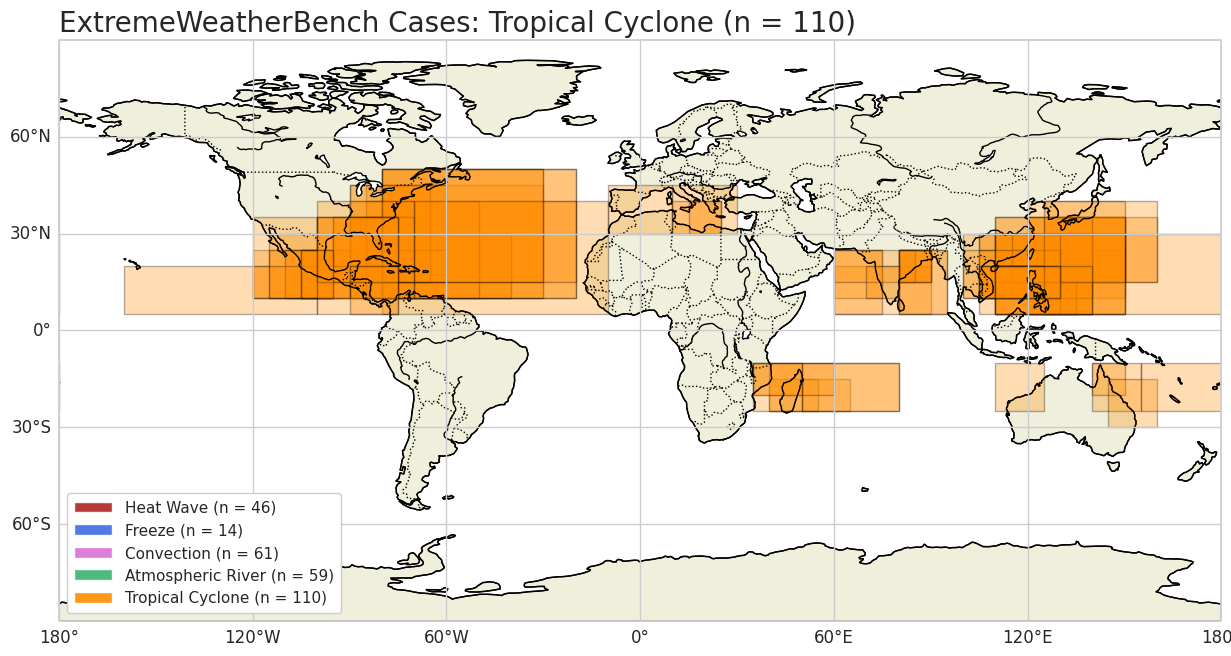

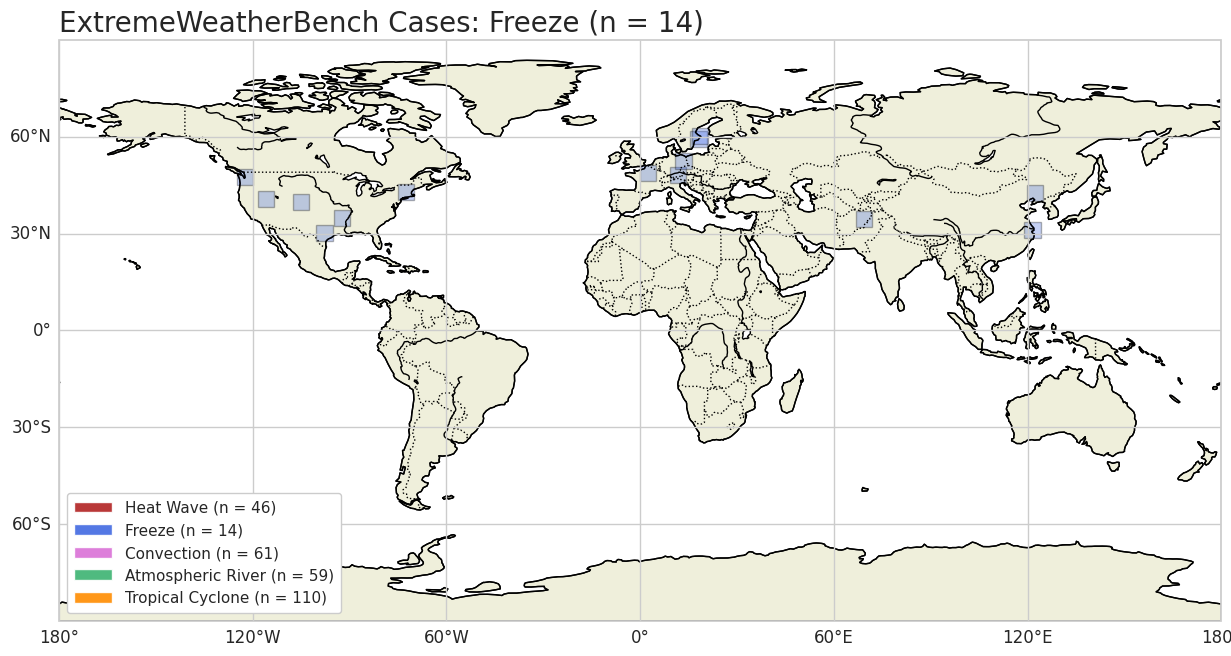

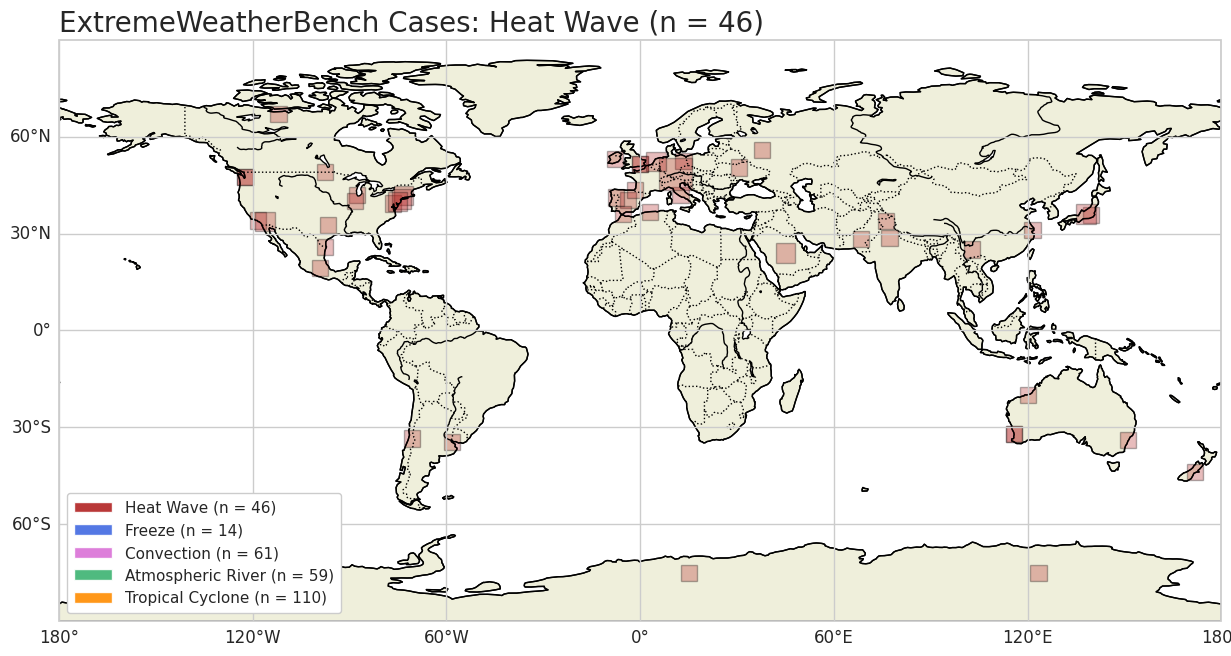

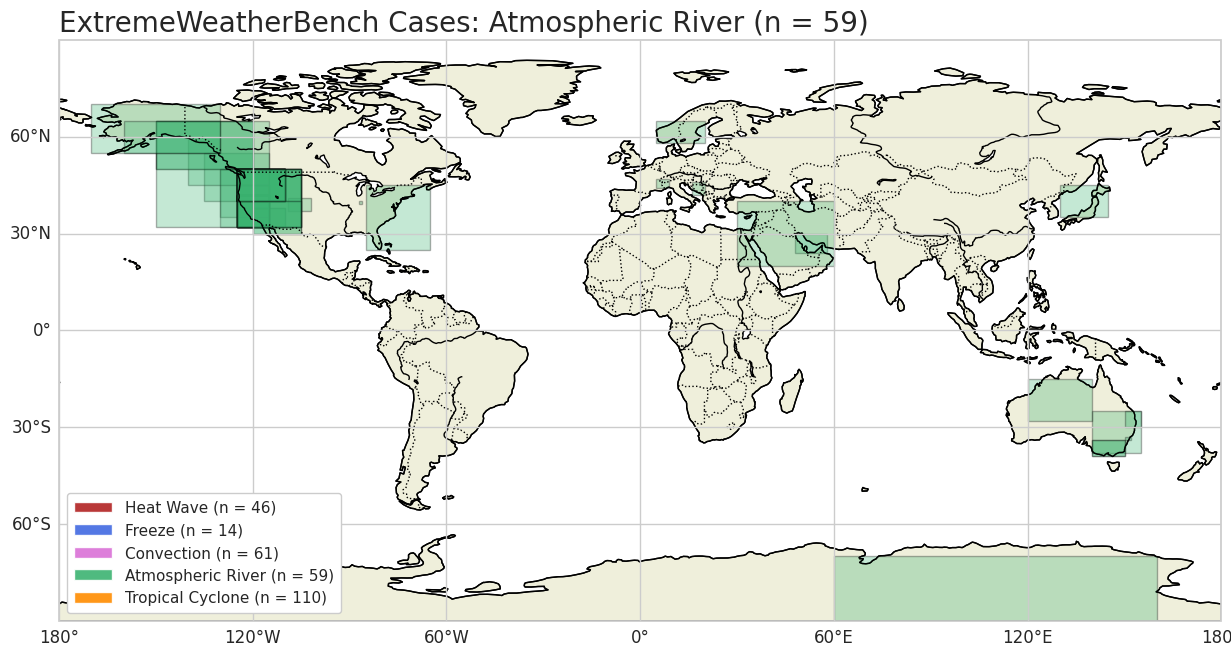

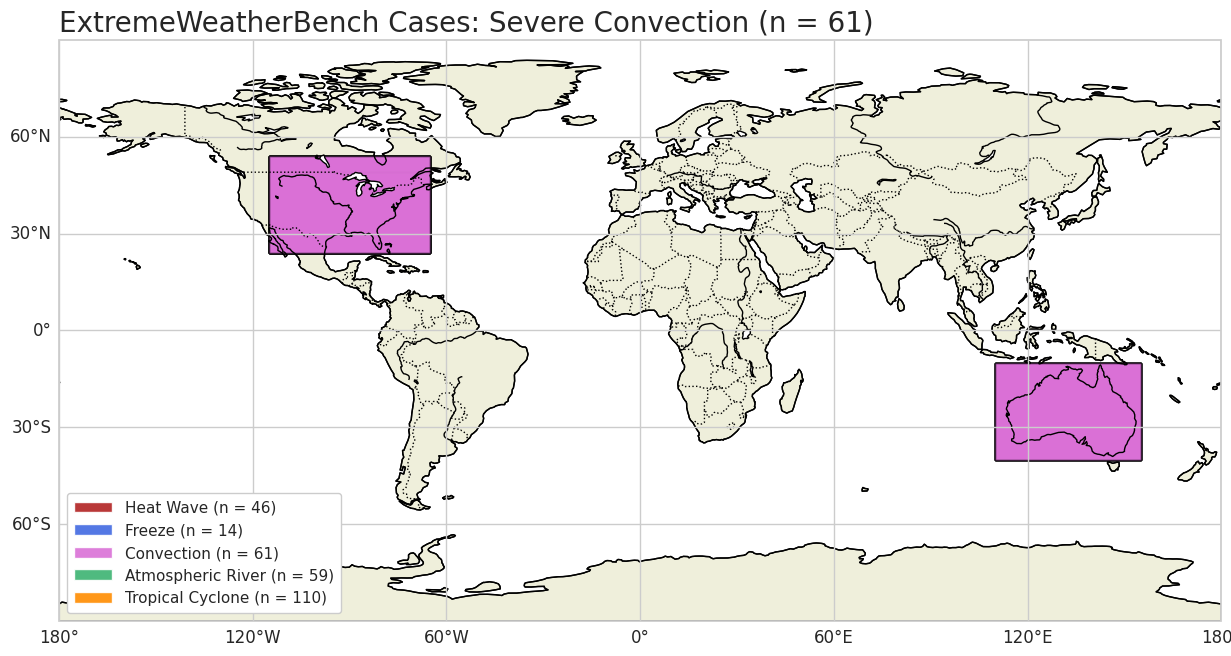

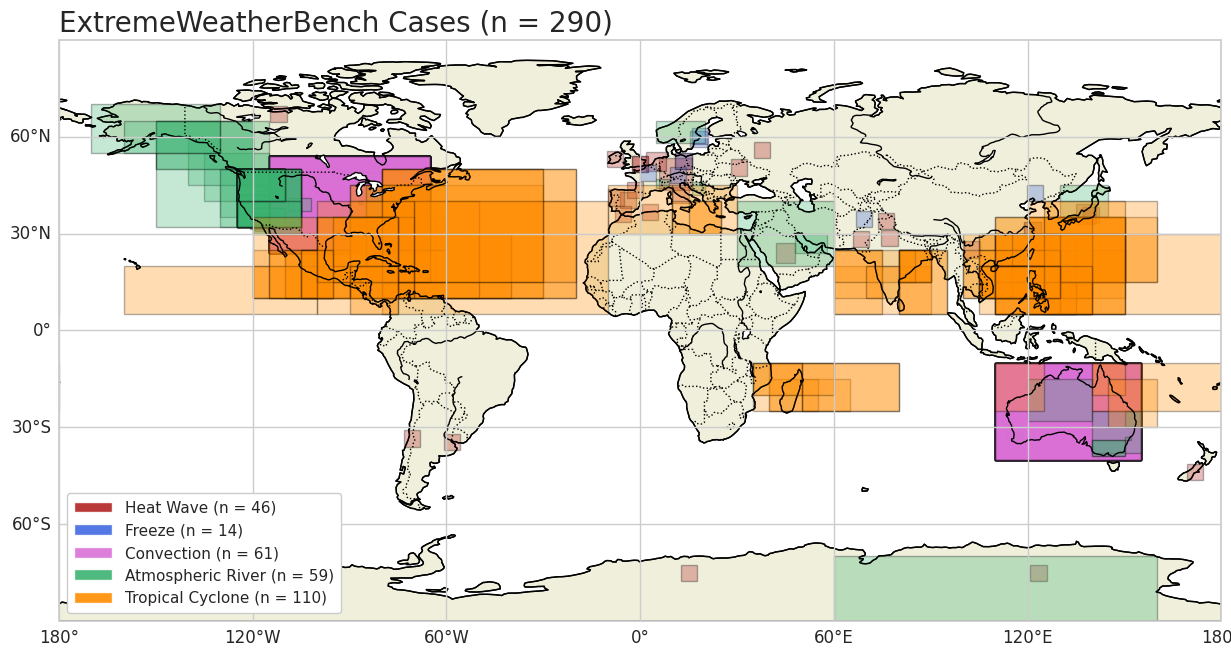

In [13]:
# plot the indivdual cases for each event type
plot_all_cases(cases, event_type='tropical_cyclone', filename='docs/notebooks/figs/ewb_tcs.png')
plot_all_cases(cases, event_type='freeze', filename='docs/notebooks/figs/ewb_freeze.png')
plot_all_cases(cases, event_type='heat_wave', filename='docs/notebooks/figs/ewb_heat.png')
plot_all_cases(cases, event_type='atmospheric_river', filename='docs/notebooks/figs/ewb_ar.png')
plot_all_cases(cases, event_type='severe_convection', filename='docs/notebooks/figs/ewb_convective.png')

# plot all cases on one giant world map
plot_all_cases(cases, event_type=None, filename='docs/notebooks/figs/ewb_all.png')

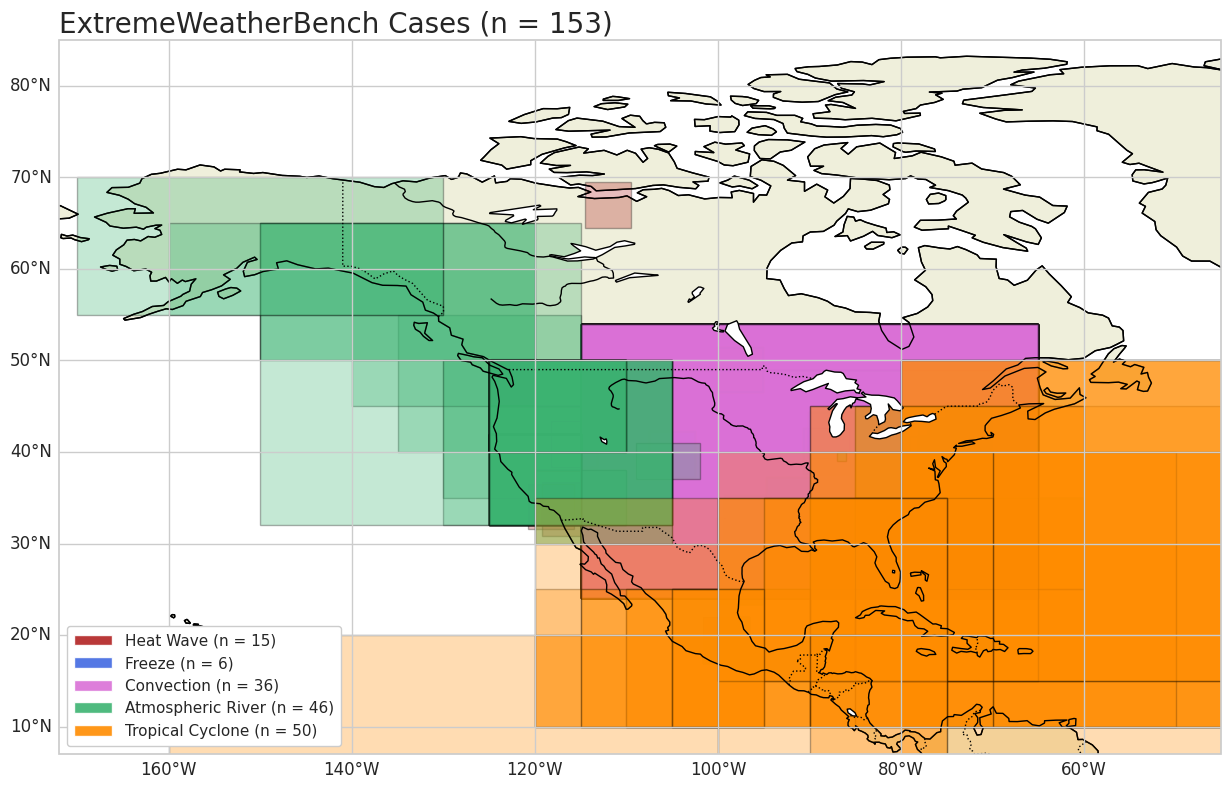

In [14]:
# plot North America
bot_lat = 7
top_lat = 85
left_lon = -172
right_lon = -45

bounding_box = [left_lon, right_lon, bot_lat, top_lat]
plot_title = 'ExtremeWeatherBench Cases in North America'

plot_all_cases(cases, event_type=None, bounding_box=bounding_box, filename='docs/notebooks/figs/extreme_weather_cases_NA.png')

50 -15 15 75


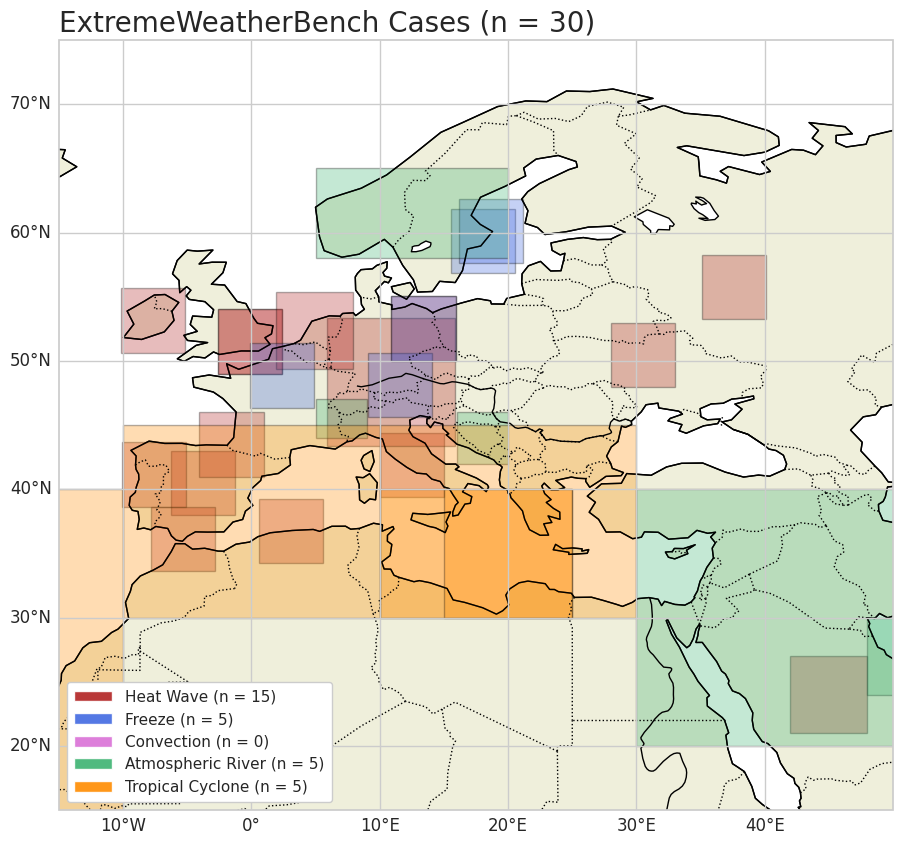

In [15]:
# plot Europe
bot_lat = 15
top_lat = 75
left_lon = -15
right_lon = 50

print(right_lon, left_lon, bot_lat, top_lat)

bounding_box = [left_lon, right_lon, bot_lat, top_lat]
plot_title = 'ExtremeWeatherBench Cases in Europe'
plot_all_cases(cases, event_type=None, bounding_box=bounding_box, filename='docs/notebooks/figs/extreme_weather_cases_Europe.png')


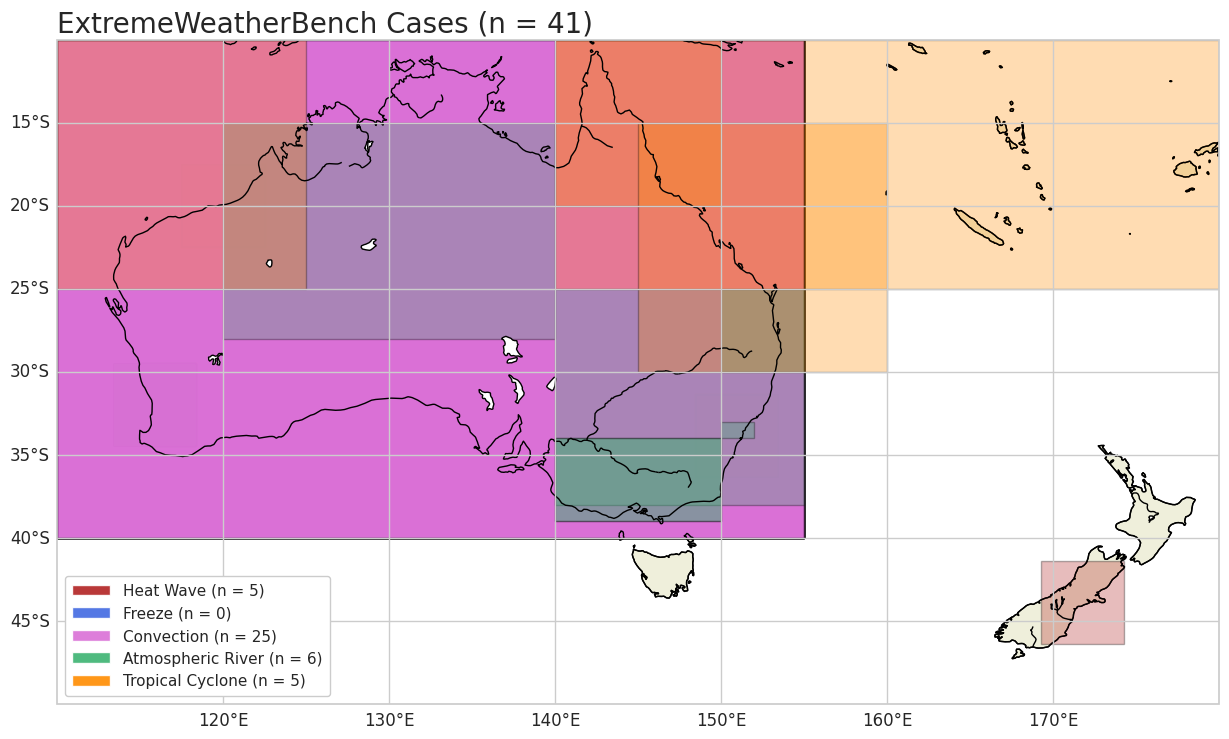

In [16]:
# plot Australia
bot_lat = -50
top_lat = -10
left_lon = 110
right_lon = 180
bounding_box = [left_lon, right_lon, bot_lat, top_lat]
plot_title = 'ExtremeWeatherBench Cases in Australia'

plot_all_cases(cases, event_type=None, bounding_box=bounding_box, filename='docs/notebooks/figs/extreme_weather_cases_Aus.png')